In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import torch.nn.functional as F
import torch_geometric
import kmbio  # fork of biopython PDB with some changes in how the structure, chain, etc. classes are defined.
import numpy as np
import pandas as pd
import proteinsolver
import modules
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, BatchSampler, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from torch import nn, optim
from pathlib import Path

from modules.dataset import *
from modules.utils import *
from modules.model import *
from modules.lstm_utils import *

### Computerome paths

energy term header = "/home/projects/ht3_aim/people/alsj/tcrpmhc/data/esm_all_features/example_array.csv"
energies = "/home/projects/ht3_aim/people/idamei/data/train_data/"

### Paths

In [2]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "metadata.csv"
processed_dir = data_root / "processed" / "tcr_binding"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "state_files" / "tcr_binding_baseline"

### Get data

In [3]:
model_dir = data_root / "raw" / "tcrpmhc"

paths = list(model_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)
metadata

,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path
0,1,AVSQSNTGKLI,ASSQLMENTEAF,NLVPMVATV,1,0,TRAV12-2,TRAJ37,TRBV4-1,TRBJ1-1,tenX,TRAV12-2*01,TRAJ37*01,TRBV4-1*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
1,2,AASEVCADYKLS,ASSYSLLRAAPNTEAF,NLVPMVATV,1,0,TRAV29DV5,TRAJ20,TRBV6-3,TRBJ1-1,tenX,TRAV29/DV5*01,TRAJ20*01,TRBV6-3*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
2,3,AGRLGAQKLV,ASSQGGRRNQPQH,NLVPMVATV,1,0,TRAV25,TRAJ54,TRBV4-2,TRBJ1-5,tenX,TRAV25*01,TRAJ54*01,TRBV4-2*01,TRBJ1-5*01,/home/sebastian/masters/data/neat_data/raw/tcr...
3,4,AVEPLYGNKLV,ASSSREAEAF,NLVPMVATV,1,0,TRAV22,TRAJ47,TRBV7-9,TRBJ1-1,tenX,TRAV22*01,TRAJ47*01,TRBV7-9*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
4,5,ASGTYKYI,ASSQRAGRVDTQY,NLVPMVATV,1,0,TRAV19,TRAJ40,TRBV27,TRBJ2-3,tenX,TRAV19*01,TRAJ40*01,TRBV27*01,TRBJ2-3*01,/home/sebastian/masters/data/neat_data/raw/tcr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,12961,AVNSYYNQGGKLI,SVLQGSPYEQY,GILGFVFTL,1,1,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,positive,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10327,12962,AGNYGGSQGNLI,ASSIYSVNEQF,GILGFVFTL,1,1,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,positive,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10328,12966,AVGGSQGNLI,ASSVRSSYEQY,GILGFVFTL,1,1,TRAV8-6*02,TRAJ42*01,TRBV19*01,TRBJ2-7*01,positive,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10329,12968,AENGGGGADGLT,ASSIRSSYEQY,GILGFVFTL,1,1,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,positive,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...


In [4]:
unique_peptides = metadata["peptide"].unique()

metadata["merged_chains"] = metadata["CDR3a"] + metadata["CDR3b"]
loo_train_partitions = list()
loo_valid_partitions = list()
for pep in unique_peptides:
    valid_df = metadata[metadata["peptide"] == pep]
    valid_unique_cdr = valid_df["merged_chains"].unique()
    
    # get training rows and drop swapped data
    train_df = metadata[metadata["peptide"] != pep]
    train_df = train_df[~train_df["merged_chains"].str.contains('|'.join(valid_unique_cdr))]

    loo_train_partitions.append(list(train_df.index))
    loo_valid_partitions.append(list(valid_df.index))

dataset = LSTMDataset(
    data_dir=processed_dir / "gnn_out_pos_128", 
    annotations_path=processed_dir / "gnn_out_pos_128" / "targets.pt"
)

# hacky dataset fix
# hacky dataset fix
# hacky dataset fix
filtered_peptides = ["CLGGLLTMV", "ILKEPVHGV"]
filtered_indices = list()
filtered_partitions = list()

for pep in filtered_peptides:
    filtered_indices.extend(list(metadata[metadata["peptide"] == pep].index))
    filtered_partitions.extend(np.where(unique_peptides == pep)[0])

loo_train_partitions = [part for i, part in enumerate(loo_train_partitions) if i not in filtered_partitions]
loo_valid_partitions = [part for i, part in enumerate(loo_valid_partitions) if i not in filtered_partitions]

filtered_indices = set(filtered_indices)

for i in range(len(loo_train_partitions)):
    train_part, valid_part = loo_train_partitions[i], loo_valid_partitions[i]
    train_part = [i for i in train_part if i not in filtered_indices]
    valid_part = [i for i in valid_part if i not in filtered_indices]
    loo_train_partitions[i], loo_valid_partitions[i] = train_part, valid_part
    
unique_peptides = np.delete(unique_peptides, filtered_partitions)

### GNN + RandomForest classifier

In [13]:
n_splits = len(unique_peptides)
save_dir = get_non_dupe_dir(out_dir)
pred_paths = touch_output_files(save_dir, "pred", n_splits)
n_estimators = 250

pad_dummy_tensor = torch.zeros((500, 128))  # some number greater than longest protein in dataset

i = 0
for train_idx, valid_idx in zip(loo_train_partitions, loo_valid_partitions):
    print(i)
    # get train input
    x_train = [dataset[i][0][:,:-4] for i in train_idx]

    # pad and reshape data to n_sample x n_feature dim
    x_train.append(pad_dummy_tensor)
    x_train = nn.utils.rnn.pad_sequence(x_train, batch_first=True, padding_value=0)
    x_train = x_train[:-1]  # remove padding tensor
    batch_dim, len_dim, embed_dim = x_train.shape
    x_train = x_train.reshape((batch_dim, len_dim * embed_dim))

    # get train labels
    y_train = torch.Tensor([dataset[i][1].item() for i in train_idx])

    # get valid input
    x_valid = [dataset[i][0][:,:-4] for i in valid_idx]

    # pad and reshape data to n_sample x n_feature dim
    x_valid.append(pad_dummy_tensor)
    x_valid = nn.utils.rnn.pad_sequence(x_valid, batch_first=True, padding_value=0)
    x_valid = x_valid[:-1]  # remove padding tensor
    batch_dim, len_dim, embed_dim = x_valid.shape
    x_valid = x_valid.reshape((batch_dim, len_dim * embed_dim))

    # get train labels
    y_valid = torch.Tensor([dataset[i][1].item() for i in valid_idx])

    # fit model and get valid preds
    clf = RandomForestClassifier(n_estimators=n_estimators)
    clf.fit(x_train.numpy(), y_train.numpy())

    pred = clf.predict_proba(x_valid.numpy())[:,1]


    torch.save({"y_pred": pred, "y_true": y_valid}, pred_paths[i])

    i += 1

0
1


KeyboardInterrupt: 

0.6067949878088631 -0.012325891762424372
0.6076923076923076 -0.04756514941544941
0.6513157894736842 0.25608661164085167
0.5748081841432225 0.003073869273923733
0.40151515151515144 -0.14414999403128945
0.5359477124183006 -0.09359995293260694
0.4104938271604938 -0.10540925533894598
0.5963636363636364 0.03178208630818641
0.43171114599686033 -0.15082288391606793
0.6758620689655173 0.06206896551724138
0.5027906976744186 -0.10199959200244799
0.43180754731902776 -0.07172120104136943
0.6807628524046435 -0.12571132112851685
0.4469179294717462 -0.05217969838640216
0.4285714285714286 -0.3779644730092272
1.0 0.0


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


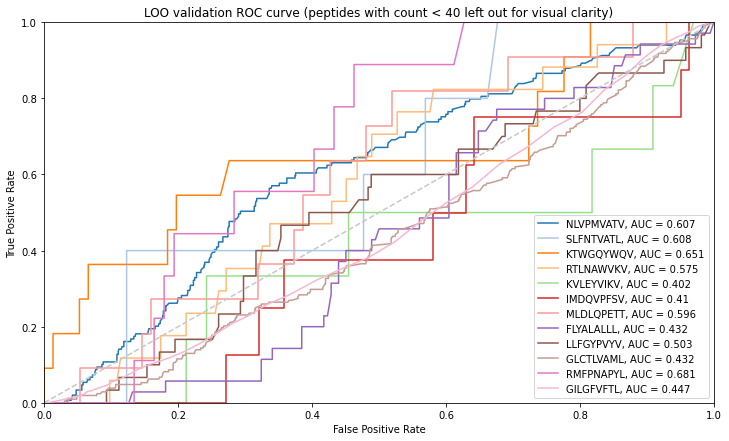

In [9]:
n_splits = len(unique_peptides)
threshold = 0.2
save_dir = Path("/home/sebastian/masters/data/state_files/tcr_binding/computerome/tcr_binding/randomforest_baseline/250/25cec4b3ceb002bbbaa3ee5147ecda47/")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(n_splits)]



# compute metrics
perf_data = dict()
for i in range(n_splits):
    data = torch.load(pred_paths[i])
    pred = data["y_pred"]
    true = data["y_true"]

    # auc
    auc = roc_auc_score(true, pred)
    fpr, tpr, thr = roc_curve(true, pred, pos_label=1)
    
    thresh_pred = torch.zeros(len(pred))
    thresh_pred[pred >= threshold] = 1
    mcc = matthews_corrcoef(true, thresh_pred)
    
    pep = unique_peptides[i]
    perf_data[pep] = [fpr, tpr, auc, mcc]

    print(auc, mcc)

performance_file = save_dir / "performance_data.pt"
torch.save(perf_data, performance_file)

# ROC plot
cm = plt.get_cmap('tab20')  # https://matplotlib.org/stable/tutorials/colors/colormaps.html

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1*i/n_splits) for i in range(n_splits)])
excluded = ["KLQCVDLHV", "KVAELVHFL", "YLLEMLWRL", "SLLMWITQV"] # TODO delete (filter <40 in test set)
for pep in unique_peptides:
    if pep not in excluded:
        ax.plot(
            perf_data[pep][0], 
            perf_data[pep][1], 
            label=f"{pep}, AUC = {round(perf_data[pep][2], 3)}",
        )
plt.legend()
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LOO validation ROC curve (peptides with count < 40 left out for visual clarity)")
plt.show()

In [ ]:
auc = roc_auc_score(y_valid, pred)
fpr, tpr, thr = roc_curve(y_valid, pred, pos_label=1)

In [ ]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
ax.plot(
    fpr, 
    tpr,
)
#    label=f"{pep}, AUC = {round(perf_data[pep][2], 3)}",
#)
plt.legend()
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LOO validation ROC curve (peptides with count < 40 left out for visual clarity)")
plt.show()
print(auc)